In [1]:
# Descargar dataset
!wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

--2022-01-10 04:39:24--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/si11cws2pyho1bp/archive.zip [following]
--2022-01-10 04:39:24--  https://www.dropbox.com/s/raw/si11cws2pyho1bp/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc222017c73d5965bf5148782635.dl.dropboxusercontent.com/cd/0/inline/BdfdFKwmp231pc9Qfg_2vMaqmf_78LGXG0cvExvsZ0S9sJY8kmnrZ_z2mHZVN92cN2r_N-HQHMTjyU5v9yZsV36_L6W9_90IQwGVmjxcTjIXGE32AGeW9kjtT5XiRZAYMeVCmzaGeW96jqf5-szWh9fK/file# [following]
--2022-01-10 04:39:24--  https://uc222017c73d5965bf5148782635.dl.dropboxusercontent.com/cd/0/inline/BdfdFKwmp231pc9Qfg_2vMaqmf_78LGXG0cvExvsZ0S9sJY8kmnrZ_z2mHZVN92cN2r_N-HQHMTjyU5v9yZsV36_L6W9_

In [2]:
# Descomprimir dataset
!unzip -q "/content/archive.zip"

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

## Parsear el dataset

In [4]:
# Rutas (path) del dataset
train_path = Path("/content/train")
test_path = Path("/content/test")

In [5]:
# Obtener la ruta de las imagenes de la carpeta de entrenamiento
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x), train_image_paths))

train_image_paths[:10]

['/content/train/fear/Training_77734669.jpg',
 '/content/train/fear/Training_34631120.jpg',
 '/content/train/fear/Training_70042615.jpg',
 '/content/train/fear/Training_72933913.jpg',
 '/content/train/fear/Training_39001074.jpg',
 '/content/train/fear/Training_1497603.jpg',
 '/content/train/fear/Training_6300419.jpg',
 '/content/train/fear/Training_48735147.jpg',
 '/content/train/fear/Training_26552601.jpg',
 '/content/train/fear/Training_257904.jpg']

In [6]:
# Obtener sus respctivas etiquetas

def obtener_etiqueta(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : obtener_etiqueta(x), train_image_paths))
train_image_labels[:10]

['fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear']

In [7]:
from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [8]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [9]:
from sklearn.model_selection import train_test_split 

Train_paths, Val_paths, Train_labels, Val_labels = train_test_split(train_image_paths, train_image_labels, test_size=0.25)

In [10]:
# Compute class weights 

classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e, weight in enumerate(classWeight)}
print(class_weight)

{0: 1.7953565, 1: 17.238853, 2: 1.756327, 3: 1.0, 4: 1.4633685, 5: 1.4965441, 6: 2.2639062}


## Cargar y transformar las imagenes

In [11]:
# Funcion para la transformacion de la imagen

def cargar_img(image, label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    return image, label

In [12]:
# Definir el tamaño de imagen (IMG_SIZE) y el tamaño del lote (BATCH_SIZE)
IMG_SIZE = 96 
BATCH_SIZE = 32

# Transformacion basica
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, -0.05))
])

In [13]:
# Crear un objeto de datos de tensorflow

AUTOTUNE = tf.data.experimental.AUTOTUNE

def obtener_dataset(paths, labels, train=True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

    dataset = dataset.map(lambda image, label : cargar_img(image, label))
    dataset = dataset.map(lambda image, label : (resize(image), label), num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label : (data_augmentation(image), label), num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset

In [14]:
# Crear dataset de entrenamiento
%time train_dataset = obtener_dataset(Train_paths, Train_labels)

image, label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 533 ms, sys: 22.5 ms, total: 556 ms
Wall time: 611 ms
(32, 96, 96, 3)
(32, 7)


happy


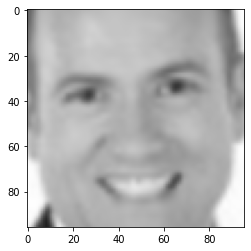

In [15]:
# Muestra de una imagen de entrenamiento
print(Le.inverse_transform(np.argmax(label, axis=1))[0])
plt.imshow((image[0].numpy()/255).reshape(96, 96, 3))

In [16]:
# Crear dataset de validacion
%time val_dataset = obtener_dataset(Val_paths, Val_labels, train=False)

image, label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 30.5 ms, sys: 0 ns, total: 30.5 ms
Wall time: 31 ms
(32, 96, 96, 3)
(32, 7)


surprise


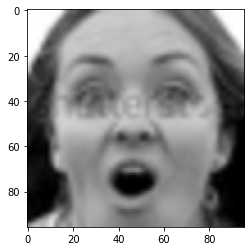

In [17]:
# Muestra de una imagen de validacion
print(Le.inverse_transform(np.argmax(label, axis=1))[0])
plt.imshow((image[0].numpy()/255).reshape(96, 96, 3))

## Construir y entrenar el modelo

In [18]:
# Contruir modelo EfficientNet
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

31801344/31790344 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 7,882,249
Non

In [19]:
# Compilar el modelo
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

El dataset consta de muchas imagenes y el problema a resolver es de multiclase. Es por esto que debemos tener cuidado con el sobre entrenamiento (overfitting).

Para evitar esto, el entrenamiento se hara en 2 fases:

Fase 1 - Capa convolucional para aprender los patrones de los datos.  
Fsae 2 - Congelamos todas las capas del modelo y solo entrenamos las ultimas capas donde hacemos la clasificacion.

## Fase 1

In [20]:
# Entrenamiento del modelo
history = model.fit(
    train_dataset,
    steps_per_epoch = len(Train_paths)//BATCH_SIZE,
    epochs = 12,
    validation_data = val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight = class_weight
)

Epoch 1/12
672/672 [==============================] - 190s 247ms/step - loss: 2.8433 - accuracy: 0.3897 - precision: 0.6283 - recall: 0.1741 - val_loss: 1.3866 - val_accuracy: 0.4738 - val_precision: 0.6512 - val_recall: 0.3037
Epoch 2/12
672/672 [==============================] - 170s 251ms/step - loss: 2.3989 - accuracy: 0.4842 - precision: 0.6910 - recall: 0.2762 - val_loss: 1.4376 - val_accuracy: 0.4393 - val_precision: 0.6028 - val_recall: 0.2930
Epoch 3/12
672/672 [==============================] - 163s 242ms/step - loss: 2.2508 - accuracy: 0.5177 - precision: 0.6954 - recall: 0.3243 - val_loss: 1.2664 - val_accuracy: 0.5234 - val_precision: 0.7074 - val_recall: 0.3336
Epoch 4/12
672/672 [==============================] - 161s 240ms/step - loss: 2.1566 - accuracy: 0.5328 - precision: 0.7053 - recall: 0.3448 - val_loss: 1.2528 - val_accuracy: 0.5225 - val_precision: 0.7271 - val_recall: 0.3491
Epoch 5/12
672/672 [==============================] - 161s 240ms/step - loss: 2.0547 - a

In [21]:
model.layers[0].trainable = False

In [22]:
# Definir callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 181,255
Non-trainable params: 7,768,569
______________________________________

## Fase 2

In [24]:
# Entrenar modelo
history = model.fit(
    train_dataset,
    steps_per_epoch = len(Train_paths)//BATCH_SIZE,
    epochs = 8,
    callbacks = [checkpoint, early_stop],
    validation_data = val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight = class_weight
)

Epoch 1/8
672/672 [==============================] - ETA: 0s - loss: 1.6898 - accuracy: 0.6225 - precision: 0.7480 - recall: 0.4829
Epoch 00001: val_loss improved from inf to 1.07855, saving model to best_weights.h5
672/672 [==============================] - 162s 241ms/step - loss: 1.6898 - accuracy: 0.6225 - precision: 0.7480 - recall: 0.4829 - val_loss: 1.0785 - val_accuracy: 0.6014 - val_precision: 0.7085 - val_recall: 0.4971
Epoch 2/8
672/672 [==============================] - ETA: 0s - loss: 1.6414 - accuracy: 0.6328 - precision: 0.7509 - recall: 0.4996
Epoch 00002: val_loss did not improve from 1.07855
672/672 [==============================] - 161s 239ms/step - loss: 1.6414 - accuracy: 0.6328 - precision: 0.7509 - recall: 0.4996 - val_loss: 1.1285 - val_accuracy: 0.5897 - val_precision: 0.6987 - val_recall: 0.4640
Epoch 3/8
672/672 [==============================] - ETA: 0s - loss: 1.6084 - accuracy: 0.6391 - precision: 0.7531 - recall: 0.5111
Epoch 00003: val_loss did not impro

## Evaluar y guardar el modelo

In [25]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape = (96, 96, 3),
    include_top = False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [26]:
model.load_weights("best_weights.h5")

In [27]:
# Crear un objeto del dataset 'probar' al igual que para el entrenamiento y la validación
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x), test_image_paths))
test_labels = list(map(lambda x : obtener_etiqueta(x), test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_imagen(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [96 , 96], method="bilinear")
    return image, label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_imagen)
    .batch(BATCH_SIZE)
)

In [28]:
# Verificar el objeto del dataset de prueba
image, label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


fear


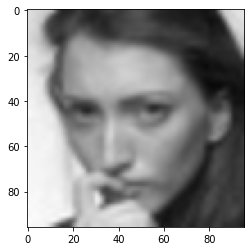

In [29]:
# Muestra de una imagen de validacion
print(Le.inverse_transform(np.argmax(label, axis=1))[0])
plt.imshow((image[0].numpy()/255).reshape(96, 96, 3))

In [30]:
# Evaluar el modelo cargado
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : ", acc)
print(" Testing Precision ", prec)
print(" Testing Recall ", rec)

225/225 [==============================] - 19s 66ms/step - loss: 1.0649 - accuracy: 0.6130 - precision: 0.7090 - recall: 0.5137
 Testing Acc :  0.6129841208457947
 Testing Precision  0.7090384364128113
 Testing Recall  0.5136528015136719


## Guardar objetos

In [31]:
# Guardar el modelo
model.save("FacialExpressionModel.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [32]:
# Guardar el Label Encoder 
import pickle

def guardar_obj(obj, name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

In [33]:
guardar_obj(Le, "LabelEncoder")